# Introduction

Welcome to the Reinforcement Learning Bachelor course!
This semester consists of 4 assignments, two of which are in the form of these Google Colab Notebooks. These first two assignments are relatively small, but should provide a gentle introduction in 2 important topics underlying reinforcement learning.

- A1A: Exploration
- **A1B: Dynamic Programming**
- A1: Model-Free Reinforcement Learning
- A2: Model-Based Reinforcement Learning



## Assignment Requirements

The first two notebook assignments require you to read the Colab carefully, complete some (small) coding blocks within the notebook and write a report.

Throughout each notebook you will find questions that should provide inspiration for discussion points in your report. At the end of the notebook there will also be a summary of how the report should look like and what it should include.

#### What to hand in

1. This notebook, with code blocks completed.
    - Hand in the notebook **with** the results (primarily the plots) under each code cell; so do not delete the cell output before downloading the file.
    - Download this notebook file via "*File > Download > .ipynb Download*".
2. A small 1-2 page double-column report, created in latex using the template linked on [the website](https://irl.liacs.nl/assignments).

Hand in both the `ipynb` and the `pdf` as standalone files (**not as a ZIP file**) on brightspace before the due date.

Both assignment 1A and 1B should be accompanied by a standalone 1-2 page report. These can be handed in as seperate pdfs, or merged into a single file.

# Assingment 1B - Dynamic Programming

This second assignment focusses on on dynamic programming (DP), which is a bridging method between planning and reinforcement learning (RL). Whereas RL learns via sampling, DP learns via (perfect) planning. As such, DP assumes full access to a "model" of the environment i.e. we can get $p(s'|s,a)$ and $r(s,a,s')$ for any state $s$ and action $a$ (In case this is not at all familiar to you, please check out week's 3 slides on MDPs).

Due to the nature of DP, there is no **exploration** involved in this assignment. However, we will still assume you have already completed the last notebook and understand all the code that was provided there.

In [ ]:
#@title Code Initialization
#@markdown <u>Please run this cell block before continuing. This will create the environment class along with some helpfull visualization tools. You can inspect the code, but it is not required to fully understand it.</u>

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle,Arrow
from IPython import display
from time import sleep

RENDER_SCALE = 0.85

# Lowering this makes the environment stochastic
# You can play around with this and see the effect on the optimal policy.
WIND_BLOWS_PROPORTION = 1.0
STEP_PAUSE=0.2

class StochasticWindyGridworld:
    ''' Stochastic version of WindyGridworld
        (Sutton & Barto, Example 6.5 at page 130, see http://incompleteideas.net/book/RLbook2020.pdf)
        Compared to the book version, the vertical wind is now stochastic, and only blows 80% of the times
    '''

    def __init__(self, initialize_model=True, reward_per_step=-1.0):
        self.height = 6
        self.width = 7
        self.start_location = (0,3)
        self.goal_location = (4,3)
        self.reward_per_step = reward_per_step
        self.goal_reward = 35
        self.shape = (self.width, self.height)
        self.n_states = self.height * self.width
        self.n_actions = 4
        self.winds = (0,0,1,2,2,1,0)
        self.wind_blows_proportion = WIND_BLOWS_PROPORTION
        self.action_effects = {
                0: (0, 1),  # up
                1: (1, 0),   # right
                2: (0, -1),   # down
                3: (-1, 0),  # left
                }
        self.initialize_model = initialize_model
        if initialize_model:
            self._construct_model()
        self.fig = None
        self.Q_labels = None
        self.arrows = None
        self.reset() # set agent to the start location

    def reset(self):
        ''' set the agent back to the start location '''
        self.agent_location = np.array(list(self.start_location))
        s = self._location_to_state(self.agent_location)
        return s

    def step(self,a):
        ''' Forward the environment based on action a, really affecting the agent location
        Returns the next state, the obtained reward, and a boolean whether the environment terminated '''
        self.agent_location += self.action_effects[a] # effect of action
        self.agent_location = np.clip(self.agent_location,(0,0),np.array(self.shape)-1) # bound within grid
        if np.random.rand() < self.wind_blows_proportion: # apply effect of wind
            self.agent_location[1] += self.winds[self.agent_location[0]] # effect of wind
        self.agent_location = np.clip(self.agent_location,(0,0),np.array(self.shape)-1) # bound within grid
        s_next = self._location_to_state(self.agent_location)

        # Check reward and termination
        if np.all(self.agent_location == self.goal_location):
            done = True
            r = self.goal_reward
        else:
            done = False
            r = self.reward_per_step

        return s_next, r, done

    def model(self,s,a):
        ''' Returns vectors p(s'|s,a) and r(s,a,s') for given s and a.
        Only simulates, does not affect the current agent location '''
        if self.initialize_model:
            return self.p_sas[s,a], self.r_sas[s,a]
        else:
            raise ValueError("set initialize_model=True when creating Environment")


    def render(self,Q_sa=None,plot_optimal_policy=False,step_pause=None):
        ''' Plot the environment
        if Q_sa is provided, it will also plot the Q(s,a) values for each action in each state
        if plot_optimal_policy=True, it will additionally add an arrow in each state to indicate the greedy action '''
        # Initialize figure
        # if self.fig == None:
        self._initialize_plot()
        if step_pause == None:
            step_pause = STEP_PAUSE

        # Add Q-values to plot
        if Q_sa is not None:
            # Initialize labels
            # if self.Q_labels is None:
            self._initialize_Q_labels()
            # Set correct values of labels
            for state in range(self.n_states):
                for action in range(self.n_actions):
                    self.Q_labels[state][action].set_text(np.round(Q_sa[state,action],1))

        # Add arrows of optimal policy
        if plot_optimal_policy and Q_sa is not None:
            self._plot_arrows(Q_sa)

        # Update agent location
        self.agent_circle.center = self.agent_location+0.5

        # Draw figure
        display.display(plt.gcf())
        display.clear_output(wait=True)
        sleep(step_pause)

    def _state_to_location(self,state):
        ''' bring a state index to an (x,y) location of the agent '''
        return np.array(np.unravel_index(state,self.shape))

    def _location_to_state(self,location):
        ''' bring an (x,y) location of the agent to a state index '''
        return np.ravel_multi_index(location,self.shape)

    def _construct_model(self):
        ''' Constructs full p(s'|s,a) and r(s,a,s') arrays
            Stores these in self.p_sas and self.r_sas '''

        # Initialize transition and reward functions
        p_sas = np.zeros((self.n_states,self.n_actions,self.n_states))
        r_sas = np.zeros((self.n_states,self.n_actions,self.n_states)) + self.reward_per_step

        for s in range(self.n_states):
            for a in range(self.n_actions):
                s_location = self._state_to_location(s)

                # if s is terminal state make it a self-loop without rewards
                if np.all(s_location == self.goal_location):
                    goal_state = self._location_to_state(self.goal_location)
                    p_sas[s,a,goal_state] = 1.0
                    r_sas[s,a,] = np.zeros(self.n_states)
                    continue

                # check what happens if the wind blows:
                next_location_with_wind = np.copy(s_location)
                next_location_with_wind += self.action_effects[a] # effect of action
                next_location_with_wind = np.clip(next_location_with_wind,(0,0),np.array(self.shape)-1) # bound within grid
                next_location_with_wind[1] += self.winds[next_location_with_wind[0]] # Apply effect of wind
                next_location_with_wind = np.clip(next_location_with_wind,(0,0),np.array(self.shape)-1) # bound within grid
                next_state_with_wind = self._location_to_state(next_location_with_wind)

                # Update p_sas and r_sas
                p_sas[s,a,next_state_with_wind] += self.wind_blows_proportion
                if np.all(next_location_with_wind == self.goal_location):
                    r_sas[s,a,next_state_with_wind]  = self.goal_reward

                # check what happens if the wind blows:
                next_location_without_wind = np.copy(s_location)
                next_location_without_wind += self.action_effects[a] # effect of action
                next_location_without_wind = np.clip(next_location_without_wind,(0,0),np.array(self.shape)-1) # bound within grid
                next_state_without_wind = self._location_to_state(next_location_without_wind)

                # Update p_sas and r_sas
                p_sas[s,a,next_state_without_wind] += (1-self.wind_blows_proportion)
                if np.all(next_location_without_wind == self.goal_location):
                    r_sas[s,a,next_state_without_wind]  = self.goal_reward

        self.p_sas = p_sas
        self.r_sas = r_sas
        return

    def _initialize_plot(self):
        self.fig, self.ax = plt.subplots(figsize=(self.width * RENDER_SCALE, self.height * RENDER_SCALE))
        self.ax.set_xlim([0,self.width])
        self.ax.set_ylim([0,self.height])
        self.ax.axes.xaxis.set_visible(False)
        self.ax.axes.yaxis.set_visible(False)

        for x in range(self.width):
            for y in range(self.height):
                self.ax.add_patch(Rectangle((x, y),1,1, linewidth=0, facecolor='k',alpha=self.winds[x]/4))
                self.ax.add_patch(Rectangle((x, y),1,1, linewidth=0.5, edgecolor='k', fill=False))

        self.ax.axvline(0,0,self.height,linewidth=5,c='k')
        self.ax.axvline(self.width,0,self.height,linewidth=5,c='k')
        self.ax.axhline(0,0,self.width,linewidth=5,c='k')
        self.ax.axhline(self.height,0,self.width,linewidth=5,c='k')


        # Indicate start and goal state
        self.ax.add_patch(Rectangle(self.start_location,1.,1., linewidth=0, facecolor='r',alpha=0.2))
        self.ax.add_patch(Rectangle(self.goal_location,1.,1., linewidth=0, facecolor='g',alpha=0.2))
        self.ax.text(self.start_location[0]+0.05,self.start_location[1]+0.75, 'S', fontsize=20, c='r')
        self.ax.text(self.goal_location[0]+0.05,self.goal_location[1]+0.75, 'G', fontsize=20, c='g')


        # Add agent
        self.agent_circle = Circle(self.agent_location+0.5,0.3)
        self.ax.add_patch(self.agent_circle)

    def _initialize_Q_labels(self):
        self.Q_labels = []
        for state in range(self.n_states):
            state_location = self._state_to_location(state)
            self.Q_labels.append([])
            for action in range(self.n_actions):
                plot_location = np.array(state_location) + 0.38 + 0.30 * np.array(self.action_effects[action])
                next_label = self.ax.text(plot_location[0],plot_location[1]+0.03,0.0,fontsize=8)
                self.Q_labels[state].append(next_label)

    def _plot_arrows(self,Q_sa):
        if self.arrows is not None:
            for arrow in self.arrows:
                arrow.remove() # Clear all previous arrows
        self.arrows=[]
        for state in range(self.n_states):
            plot_location = np.array(self._state_to_location(state)) + 0.5
            max_actions = full_argmax(Q_sa[state])
            for max_action in max_actions:
                new_arrow = arrow = Arrow(plot_location[0],plot_location[1],self.action_effects[max_action][0]*0.2,
                                          self.action_effects[max_action][1]*0.2, width=0.05,color='k')
                ax_arrow = self.ax.add_patch(new_arrow)
                self.arrows.append(ax_arrow)

def full_argmax(x):
    ''' Own variant of np.argmax, since np.argmax only returns the first occurence of the max '''
    return np.where(x == np.max(x))[0]

## The Environment

You will study DP on the *Windy GridWorld*, an adapted version of Example 6.5 (page 130) in *Reinforcement Learning: An Introduction (second edition)* by Sutton and Barto. Provided you have ran the cell above, you can visualize the environment by running the cell below.

The environment consists of a 7x6 grid, where at each cell we can move up, down, left or right. We start at location (0,3) (we start indexing at 0, as is done in Python as well), indicated in the figure by ‘S’. Our goal is to move to location (4,3), indicated by ‘G’. However, a special feature of the environment is that there is a vertical wind. In columns 2 and 5, we are pushed one additional step up, while in columns 3 and 4, we move up two additional steps. The reward of the agent at each step is -1, while reaching the goal gives a reward of +35, and terminates the episode.

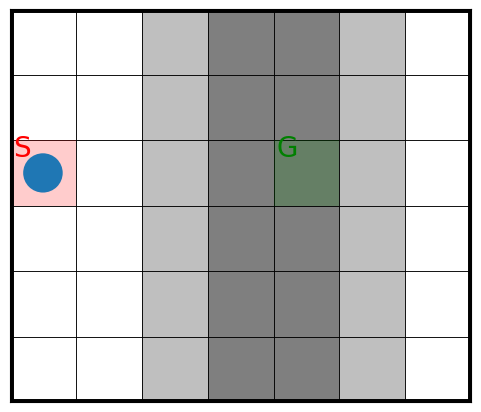

In [ ]:
env = StochasticWindyGridworld()
s = env.reset()
env.render(Q_sa=None,plot_optimal_policy=False,step_pause=1.) # display the environment

## The Agent

Below, we have implemented a `PolicyIterationAgent`, a dynamic programming agent. This implementation is quite explicit, and you will have to create a simplified improvement later. For now, this verbose implementation allows us to highlight some important characteristics in any kind of agent.

### The Policy and Selecting Actions

We have introduced **policy $π$** in the previous assignment and explained how its usually implemented implicitely. Here, to better highlight what is going on, we will be a bit more explicit and include the actual action distribution as part of the agent. The policy (`self.policy`) is therefor represented as a 2D array where each row represents a state and gives the probabilities of selecting each action in that state (so the rows should sum up to 1.0).
If our policy is *greedy*, we have a 100% chance of selecting a single action in each state, and 0% chance of selecting other actions.
In `select_action()`, we now sample from our policy.

Our goal is still to find the optimal policy ($π^*$), so the training loop now explicitely updates the policy via `update_policy()`. Here, we change the probabilities to be greedy with respect to our Q-values. This should give us the best possible improvement in our policy, given that our Q-values are good estimates.

### The Q-values

Similar to our bandit agents of the previous assignment, our new agent will store Q-values for each action. Because we are now concerned with states, the Q-arrray is transformed into a 2D Q-table.
Furthermore, it is important to realize that Q-values are not just the expected reward from a given action in a state. Instead, they represent the expected reward from a given action in a state **and** the (discounted) rewards we obtain by thereafter following policy $π$ (We will get into the discounted part later). As such, Q-values (or state-values $V_π$, see slides) are **always** conditioned on a policy -- hence $Q_π$.

A mathematical formulation for $Q_π$ is given by the bellman-equations, which are the foundation for updating $Q_π$ in dynamic programming:
$$
Q_π(s,a) \gets \sum_{s',r}p(s',r|s,a)[r+\sum_{a'}p(a'|π) \cdot Q(s',a')].
$$

Carefully study the equation above (and/or `update_Q` function below). You will notice the $Q_π(s,a)$ is partly defined by $Q_π(s',a')$ (the next state and action). As a result, $Q_π(s',a')$ needs to be a correct estimate first.
We can achieve this by repeatedly applying the function on all state-action pairs.
If you run the below code block, this is visualized. The training loop will loop over each state-action pair and update the Q-values (starting at the bottom left) and this process is repeated multiple times. We will discuss the training loop below the code block.
***
Stop running the code cell below once you've seen enough, as running the full cycle will take a long time. Also, don't be alarmed of the image flashing on every update. This is due to how the colab notebook deals with dynamic visualizations.
***

In [ ]:
class PolicyIterationAgent():
    def __init__(
            self,
            n_states,
            n_actions,
            transition_model, # DP agents require a perfect model
            reward_model, # DP agents require a perfect model
        ):
        self.n_states = n_states
        self.n_actions = n_actions
        self.Q = np.zeros((n_states, n_actions)) # Initialize our estimates at 0
        self.policy = np.ones((n_states, n_actions)) / n_actions # Initialize fully random policy

        self.p_sas = transition_model
        self.r_sas = reward_model

    def select_action(self, s):
        """ Sample an action for state s from our policy """
        return np.random.choice(self.n_actions, p=self.policy[s])

    def update_Q(self, s, a):
        """ Update our estimated sum of rewards given the current policy (Q) """

        self.Q[s, a] = np.sum(
            self.p_sas[s, a] * (
                self.r_sas[s, a] + np.sum(
                    self.policy * self.Q , axis=1
                )
            )
        )

    def update_policy(self):
        """ Update our policy by choosing the greedy action for each state """
        for s in range(self.n_states):
            best_action = np.argmax(self.Q[s]) # <-- takes the first best action
            self.policy[s] = np.zeros(self.n_actions)
            self.policy[s, best_action] = 1.0

            # We could also split the percentages over all best actions (in case of ties):
            # best_actions = np.argwhere(self.Q[s] == np.max(self.Q[s])).flatten()
            # self.policy[s] = np.isin(np.arange(self.n_actions), best_actions).astype(int) / len(best_actions)

    def train(self, threshold=0.01, eval_iterations=np.inf, render_fn=None, verbose=0):
        """ Trains the agent via Policy Iteration """

        if eval_iterations == np.inf:
            eval_iterations = 9e10 # cannot loop over inf float, so we just change it to something big

        while True:
            current_policy = self.policy.copy() # To check if the policy is stable
            for i in range(int(eval_iterations)):
                if verbose > 0:
                    print("Policy Evaluation iteration: ", i + 1)
                current_Q = self.Q.copy() # To check if Q is stable
                for s in range(self.n_states):
                    for a in range(self.n_actions):
                        self.update_Q(s, a)
                        if render_fn is not None:
                            render_fn(Q_sa=self.Q)
                delta = np.max(np.abs(current_Q - self.Q))
                if delta < threshold:
                    break
            self.update_policy()
            policy_delta = np.max(np.abs(current_policy - self.policy))
            if policy_delta < threshold:
                break

STEP_PAUSE = 0.5
env = StochasticWindyGridworld()
agent = PolicyIterationAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    transition_model=env.p_sas,
    reward_model=env.r_sas
)
agent.train(render_fn=env.render)

KeyboardInterrupt: 

## Policy Iteration - Train Loop

We now know how to update $Q_π$ for any $(s,a)$-pair and how we can use $Q_π$ to improve policy π. We also know that to calculate $Q_π$ -- we have to apply the update rule multiple times to every state-action pair. In fact, we have to apply the update rule an infinite amount of times to calculate it exactly.
Since we often lack an infinite amount of time, we typically set some threshold value and stop updating when the changes in $Q_π$ become smaller than this value. Knowing all this, you should be able to understand why the below psuodocode (and the implemented training loop above) works.

<img width="75%" src='https://drive.usercontent.google.com/download?id=1-QTdMgiewixcj2ad_9IawadDxXErtVLr' />

Run the code cell below to run the full training loop (without the intermediate plotting). This should take roughly a minute or two and end with a nice plot showing the converged Q-values along with the best action to take in each state.



In [ ]:
env = StochasticWindyGridworld()
agent = PolicyIterationAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    transition_model=env.p_sas,
    reward_model=env.r_sas
)
agent.train(verbose=1)
env.render(Q_sa=agent.Q, plot_optimal_policy=True)

Just to recap, the training loop we just discribed just consists of two phases:

1. **Policy Evaluation**: We obtain the (near) exact values for $Q_π$ by iteratively applying the bellman-equation for $Q$ on every state-action pair;
2. **Policy Improvement**: We change the policy to behave greedy with respect with the new $Q_π$.

This two-step process is known as **policy iteration** and is garentueed to converge on the optimal policy in **any** finite MDP.
You will notice though, that it took almost two minutes to solve this very simple problem... This time was mostly spend in the **policy evaluation** phase. After it found correct $Q_π$, the policy updated to the optimal policy almost instantly.

Luckily, we can make a shortcut in the training process. Try rerunning the training loop below with a few different (low) values for `eval_iterations`. The **(1) policy evaluation** phase will now quit early, before the threshold is met.

In [ ]:
eval_iterations =     # Try some low values -- go as low as 1

env = StochasticWindyGridworld()
agent = PolicyIterationAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    transition_model=env.p_sas,
    reward_model=env.r_sas
)
agent.train(verbose=1, eval_iterations=eval_iterations)
env.render(Q_sa=agent.Q, plot_optimal_policy=True)

As you will see, we converged on the same policy **far** quicker. It turns out that in order to do a **policy improvement**, we do not need $Q_π$ to have converged at all. All we need, is for our Q-values to have *moved* to a better estimate of $Q_\pi$ -- which already happened after applying the bellman equation once. In fact, in the training loop code above, we can move the `self.update_policy()` line right behind the `self.update_Q()`. Of course, we require a few more **policy improvement** steps in our new setup, but the entire loop is often much quicker.

We use the term **generalized policy iteration (GPI)** for any two-step process of policy evaluation and policy improvement with arbitrary granularities. Importantly, **ALL** current reinforcement learning algorithms are part of the GPI class algorithms -- including state-of-the-art deep learning based methods used to create AlphaGo or to align ChatGPT. In most algorithms though, parts of the process are implicit (like updating the policy).



### Egreedy Policy Iteration

In the bandit assignment, you came across various policies. Often, $π^*$ will be a greedy policy and will therefor typically use DP to find us the best greedy policy. However, note that DP will optimize *any* policy.

Implement the ϵ-greedy policy of the previous assignment in the agent below and observe the final Q-values.

In [ ]:
class EgreedyPolicyIterationAgent(PolicyIterationAgent):
    def update_policy(self):
        epsilon = 0.25
        raise NotImplementedError("Implement an update to the egreedy policy")

env = StochasticWindyGridworld()
agent = EgreedyPolicyIterationAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    transition_model=env.p_sas,
    reward_model=env.r_sas
)
agent.train(verbose=0, eval_iterations=1)
env.render(Q_sa=agent.Q, plot_optimal_policy=True)

## Value Iteration

Knowing that we can skip a lot of policy evaluation steps, we can create a more efficient and simpler DP algorithm known as **Value Iteration**. It is up to you to construct this agent below and report on its performance in your report.

You can find the psuodo-code for value iteration below. Some remarks before you continue:

- Note the updated update rule that you will have to implement. You will also notice a $γ$ in the update rule. $γ \leq 1.0$ is known as the discount factor. With $γ < 1$ we weigh future rewards less then current rewards. For example, we may simulate an agent that favors gaining money now over gaining the same amount of money in the future. However, there are other reasons we include $γ$, which you should discuss in your report.
- The `ValueIterationAgent` does not require an explicit policy as it can directly select an action based on the current Q-values. In turn, line 9 occurs implicitely when correctly implementing the `select_action` function.

<img width="75%" src='https://drive.usercontent.google.com/download?id=1-RrTMroIAwc4mm53u3A3MK9fe1aQO7Uc' />

In [ ]:
class ValueIterationAgent():
    def __init__(
            self,
            n_states,
            n_actions,
            transition_model, # DP agents require a perfect model
            reward_model, # DP agents require a perfect model
            gamma=1.0
        ):
        self.n_states = n_states
        self.n_actions = n_actions
        self.Q = np.zeros((n_states, n_actions)) # Initialize our estimates at 0
        self.gamma = gamma

        self.p_sas = transition_model
        self.r_sas = reward_model

    def select_action(self, s):
        raise NotImplementedError()

    def update_Q(self, s, a):
        raise NotImplementedError()

    def train(self, threshold=0.01, render_fn=None, verbose=0):
        raise NotImplementedError()

env = StochasticWindyGridworld()
agent = ValueIterationAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    transition_model=env.p_sas,
    reward_model=env.r_sas
)
agent.train()
env.render(Q_sa=agent.Q, plot_optimal_policy=True)

We now slightly change the environment by changing the reward per step to 0. What happens if you train your agent? Instantiate a new agent `ValueIterationAgent` that can once again solve the task.

In [ ]:
env = StochasticWindyGridworld(reward_per_step=0.0)
agent = ValueIterationAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    transition_model=env.p_sas,
    reward_model=env.r_sas,
)
agent.train()
env.render(Q_sa=agent.Q, plot_optimal_policy=True)

# Report Summary

Along with this notebook, you are to hand in a 1-2 page two-column report which summarizes this notebook, and discusses the different algorithms and results you obtained.

**General guidelines:**
- Assignment reports should be a standalone work. Instead of reading a solution to an assignment, the report should be structured and feel like a short academic paper. [The website](https://irl.liacs.nl/assignments) lists some example reports.
- Make sure you use the template linked on [the website](https://irl.liacs.nl/assignments)
- You can omit the abstract, but make sure you have a strong introduction: What is the paper about, why is that important, how are we tackling that problem etc.
- Going over the page limit (excluding references) will subtract 1 point per half page.
- Make sure to include some steps for future work. For example, can certain elements be combined? Be precise on how these next steps would look like.
- When displaying and discussing results, never only type down what we can all see in the figure/table. Instead, reason about your results. Explain why you think we observe them and what we can deduce.
- When an environment is involved, make sure this is (briefly) introduced to the reader.

**These items should be discussed in your report:**
- What is an MDP
    - Discuss its elements and various reasons we include γ (gamma) (You can use the setting with `reward_per_step=0` environment as an example here).
- Explain GPI
- What is dynamic programming and what is used for
    - what are its advantages and disadvantages
    - Relate DP back to GPI
- You can use Policy Iteration and Value iteration as examples in your report for the explanations of DP and/or GPI, but you are not required to explain both algorithms in detail. I.e. explain them intuitively, but do not provide full psuodocode.
- Include at least one image of the WindyGridWorld with the the fully trained Q-values and optimal path + one image with the Q-values of a policy other than the greedy policy. Discuss these plots.
